In [1]:
#Import libraries
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
from pandas import *

In [2]:
#Loading data
rfm = pd.read_csv('../data/rfm.csv', encoding = 'utf-8',index_col=None, sep = '\t')
rfm.head()

,CustomerID,frequency,monetary_value,recency,r_quartile,f_quartile,m_quartile
0,12820.0,59,942.34,3,1,2,2
1,12821.0,6,92.72,214,4,4,4
2,12822.0,46,948.88,70,3,2,2
3,12823.0,5,1759.50,74,3,4,1
4,12824.0,25,397.12,59,3,3,3


In [5]:
segt_map = {
    r'[1-2][1-2]': 'hibernating',
    r'[1-2][3-4]': 'at risk',
    r'[1-2]5': 'can\'t loose',
    r'3[1-2]': 'about to sleep',
    r'33': 'need attention',
    r'[3-4][4-5]': 'loyal customers',
    r'41': 'promising',
    r'51': 'new customers',
    r'[4-5][2-3]': 'potential loyalists',
    r'5[4-5]': 'champions'
}

rfm['Segment'] = rfm['r_quartile'].map(str) + rfm['f_quartile'].map(str)
rfm['Segment'] = rfm['Segment'].replace(segt_map, regex=True)
rfm.head()


,CustomerID,frequency,monetary_value,recency,r_quartile,f_quartile,m_quartile,Segment
0,12820.0,59,942.34,3,1,2,2,hibernating
1,12821.0,6,92.72,214,4,4,4,loyal customers
2,12822.0,46,948.88,70,3,2,2,about to sleep
3,12823.0,5,1759.50,74,3,4,1,loyal customers
4,12824.0,25,397.12,59,3,3,3,need attention


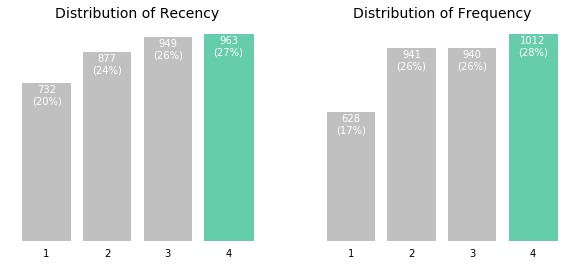

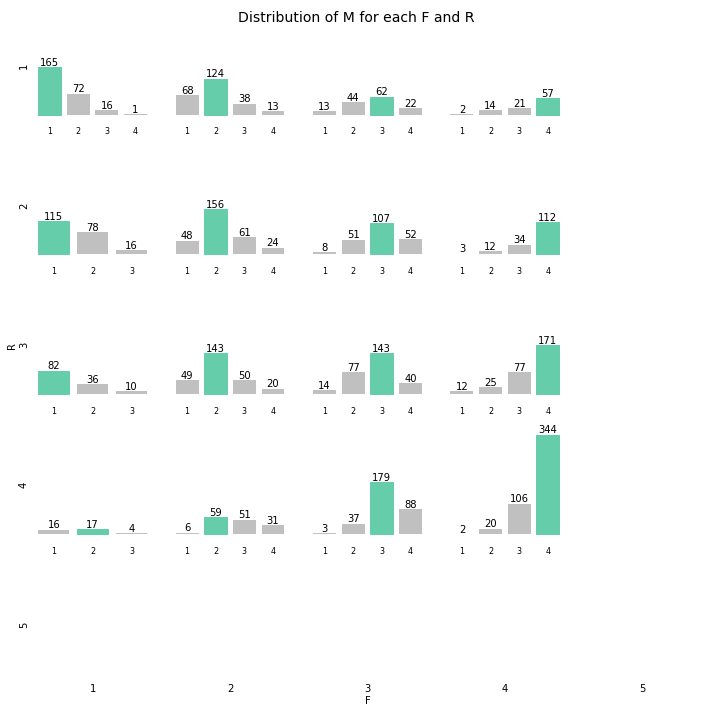

In [17]:
# plot the distribution of customers over R and F
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

for i, p in enumerate(['r_quartile', 'f_quartile']) :
    parameters = {'r_quartile':'Recency', 'f_quartile':'Frequency'}
    y = rfm[p].value_counts().sort_index()
    x = y.index
    ax = axes[i]
    bars = ax.bar(x, y, color='silver')
    ax.set_frame_on(False)
    ax.tick_params(left=False, labelleft=False, bottom=False)
    ax.set_title('Distribution of {}'.format(parameters[p]),
                fontsize=14)
    for bar in bars:
        value = bar.get_height()
        if value == y.max():
            bar.set_color('mediumaquamarine')
        ax.text(bar.get_x() + bar.get_width() / 2,
                value - 5,
                '{}\n({}%)'.format(int(value), int(value * 100 / y.sum())),
               ha='center',
               va='top',
               color='w')
        
plt.show()

# plot the distribution of M for RF score
fig, axes = plt.subplots(nrows=5, ncols=5,
                         sharex=False, sharey=True,
                         figsize=(10, 10))

r_range = range(1, 6)
f_range = range(1, 6)
for r in r_range:
    for f in f_range:
        y = rfm[(rfm['r_quartile'] == r) & (rfm['f_quartile'] == f)]['m_quartile'].value_counts().sort_index()
        x = y.index
        ax = axes[r - 1, f - 1]
        bars = ax.bar(x, y, color='silver')
        if r == 5:
            if f == 3:
                ax.set_xlabel('{}\nF'.format(f), va='top')
            else:
                ax.set_xlabel('{}\n'.format(f), va='top')
        if f == 1:
            if r == 3:
                ax.set_ylabel('R\n{}'.format(r))
            else:
                ax.set_ylabel(r)
        ax.set_frame_on(False)
        ax.tick_params(left=False, labelleft=False, bottom=False)
        ax.set_xticks(x)
        ax.set_xticklabels(x, fontsize=8)

        for bar in bars:
            value = bar.get_height()
            if value == y.max():
                bar.set_color('mediumaquamarine')
            ax.text(bar.get_x() + bar.get_width() / 2,
                    value,
                    int(value),
                    ha='center',
                    va='bottom',
                    color='k')
fig.suptitle('Distribution of M for each F and R',
             fontsize=14)
plt.tight_layout()
plt.show()

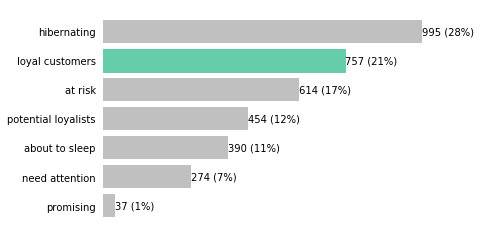

In [10]:
# count the number of customers in each segment
segments_counts = rfm['Segment'].value_counts().sort_values(ascending=True)

fig, ax = plt.subplots()

bars = ax.barh(range(len(segments_counts)),
              segments_counts,
              color='silver')
ax.set_frame_on(False)
ax.tick_params(left=False,
               bottom=False,
               labelbottom=False)
ax.set_yticks(range(len(segments_counts)))
ax.set_yticklabels(segments_counts.index)

for i, bar in enumerate(bars):
        value = bar.get_width()
        if segments_counts.index[i] in ['champions', 'loyal customers']:
            bar.set_color('mediumaquamarine')
        ax.text(value,
                bar.get_y() + bar.get_height()/2,
                '{:,} ({:}%)'.format(int(value),
                                   int(value*100/segments_counts.sum())),
                va='center',
                ha='left'
               )

plt.show()

In [7]:
X = rfm.iloc[:, 1:7]
y = rfm.Segment
y.nunique()

7

In [8]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
label = le.fit_transform(y)

rfm['cluster'] = label 

rfm.sample(10)

y = rfm.cluster

In [9]:
#Train, val and test split
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val= train_test_split(X,y, test_size=0.3)

X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.3)

In [10]:
#Standardization of our datas
from sklearn.preprocessing import StandardScaler
import pickle

# Create scaler object
scaler = StandardScaler() 
#Fit scalar object to our train set
scaler.fit(X_train)

#Save the model
#filename = 'standardization.pkl'
#pickle.dump(scaler, open(filename, 'wb'))

#Transform train, val and test into standardize datas
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

/home/celiabayet/.local/lib/python2.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/celiabayet/.local/lib/python2.7/site-packages/ipykernel_launcher.py:15: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  from ipykernel import kernelapp as app
/home/celiabayet/.local/lib/python2.7/site-packages/ipykernel_launcher.py:16: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  app.launch_new_instance()
/home/celiabayet/.local/lib/python2.7/site-packages/ipykernel_launcher.py:17: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


In [11]:
# Import the model we are using
from sklearn.ensemble import RandomForestClassifier
# Instantiate model with 1000 decision trees
rf = RandomForestClassifier(n_estimators = 1000, random_state = 42)

#Fit to our data
rf.fit(X_train, y_train);

In [12]:
y_val_pred = rf.predict(X_val)
pd.crosstab(y_val, y_val_pred, rownames=['Actual Cluster'], colnames=['Predicted Cluster'])

Predicted Cluster,0,1,2,3,4,5,6
Actual Cluster,,,,,,,
0,80,0,0,0,0,0,0
1,0,142,0,0,0,0,0
2,0,0,202,0,0,0,0
3,0,0,0,150,0,0,0
4,0,0,0,0,45,0,0
5,0,0,0,0,0,110,0
6,0,0,0,0,0,0,10


In [13]:
list(zip(X_train, rf.feature_importances_))

[(array([-0.39725672, -0.65993641, -0.95611045, -1.48162163,  0.31459873,
          0.32919327]), 0.24725933715843712),
 (array([ 0.36239719,  0.15555889, -0.77839642, -0.56227746, -0.62046914,
         -0.61398372]), 0.03523606691845039),
 (array([-0.87424871, -0.65799559,  1.2356959 ,  1.27641088,  1.2496666 ,
          0.32919327]), 0.22979150483160007),
 (array([-0.92724782, -0.68980074,  0.56433179,  1.27641088,  1.2496666 ,
          1.27237025]), 0.2244496270775044),
 (array([ 1.95237049,  0.86626215, -0.93636444, -1.48162163, -1.55553701,
         -1.5571607 ]), 0.2496726397115732),
 (array([-0.6445859 , -0.82296511,  2.08477404,  1.27641088,  0.31459873,
          1.27237025]), 0.013590824302435496)]

In [14]:
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_val, y_val_pred))

('Accuracy:', 1.0)
